# Sistemas de Información Geográfica (SIG)

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


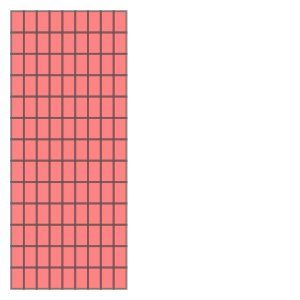

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import gmaps
import gmaps.datasets
import matplotlib.pyplot as plt
from pyproj import Proj

# Import necessary geometric objects from shapely module

from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box
import fiona

nys = Proj(init='EPSG:3857')

# Create Point geometric object(s) with coordinates
point1 = Point(-74.2235814249999, 4.836779094841296)
point2 = Point(-73.98653427799991, 4.836779094841296)
point3 = Point(-73.98653427799991, 4.269664096859796)
point4 = Point(-74.2235814249999, 4.269664096859796)

p1_proj = nys(point1.x, point1.y)
p2_proj = nys(point2.x, point2.y)
p3_proj = nys(point3.x, point3.y)
p4_proj = nys(point4.x, point4.y)

#longitud_base = point1.distance(point2)
#longitud_altura = point2.distance(point3)

longitud_base = Point(p1_proj).distance(Point(p2_proj))
longitud_altura = Point(p2_proj).distance(Point(p3_proj))

b1 = 3000
h1 = 5000


#topLeft = point1
#topRight = Point(point1.x + math.ceil(longitud_base/b1)*b1, point2.y)
#bottomRight = Point(topRight.x, point2.y - math.ceil(longitud_altura/h1)*h1)
#bottomLeft = Point(point1.x, bottomRight.y) 

topLeft = p1_proj
topRight = Point(Point(p1_proj).x + math.ceil(longitud_base/b1)*b1, Point(p2_proj).y)
bottomRight = Point(topRight.x, Point(p2_proj).y - math.ceil(longitud_altura/h1)*h1)
bottomLeft = Point(Point(p1_proj).x, bottomRight.y) 

poligono_mayor = Polygon([topLeft, topRight, bottomRight, bottomLeft])


#num_cols = 10
#num_rows = 20

cols = np.linspace(np.array(bottomLeft)[0], np.array(bottomRight)[0], math.ceil(longitud_base/b1) + 1) 
rows = np.linspace(np.array(topLeft)[1], np.array(bottomLeft)[1], math.ceil(longitud_altura/h1) + 1)     

poligonos = [Polygon([Point(cols[i], rows[j]), Point(cols[i+1], rows[j]), Point(cols[i+1], rows[j+1]), 
                      Point(cols[i], rows[j+1]), Point(cols[i], rows[j])]) for i in range(len(cols)-1) 
             for j in range(len(rows)-1)]
poligonos_series = gpd.GeoSeries(poligonos)

grid = MultiPolygon(poligonos)
grid

## Importamos Dataframes para los covariados

In [12]:
################## Dataframe con los poligonos de las localidades de Bogotá #################
polig_loc_df = gpd.read_file('poligonos-localidades.geojson')
polig_loc_df = polig_loc_df.drop([2]).reset_index()
#polig_loc_df.crs = "EPSG:3857"


################## DataFrame de los Restaurantes y Bares en Bogotá 2020 #################
#rest_bar_df = gpd.read_file("https://datosabiertos.bogota.gov.co/dataset/b0c66a77-3230-4d0c-a119-dead7f9b8b8e/resource/9c3829e3-6b4b-4aac-a3e5-297fe0127b67/download/egba.geojson")
#rest_bar_df.crs = "EPSG:3857"
################## DataFrame de las Estaciones de Policia en Bogotá 2020 #################
#est_pol_df = gpd.read_file("https://datosabiertos.bogota.gov.co/dataset/01cf1c3e-e077-4d38-86e6-bda3ff6cd645/resource/eae94a3a-034f-48c7-98a6-8aa30c3805f8/download/estacionpolicia.geojson")
#est_pol_df.crs = "EPSG:3857"

################## DataFrame con los Poligonos de Monitoreo 2020 #################
#CONTIENE CARACTERÍSTICAS NO ENTENDIDAS (VALORES COMO ocutotal ENTRE OTROS) LOS CUALES PODRÍAN MEJORAR LA CALIDAD
#DEL DATASET. POR EL MOMENTO, SOLO UTILIZAREMOS EL ÁREA INTERSECTADA
# El set de datos contiene información de las áreas o territorio identificados como una zona susceptible o en proceso 
# de desarrollo ilegal, ya sea por asentamiento o enajenación; los cuales son objeto de vigilancia y seguimiento para 
# adelantar labores de prevención a la ocupación y al desarrollo ilegal en el marco de las competencias de la SDHT.
#pol_mon_df = gpd.read_file('https://www.datos.gov.co/api/geospatial/xt98-rz23?method=export&format=GeoJSON')
#pol_mon_df['centroid'] = pol_mon_df['geometry'].map(lambda x: x.centroid)
#pol_mon_df.crs = "EPSG:3857"

#########################  DataFrame de Sistema Distrital de Parques y Escenarios Públicos Deportivos 2020 ######################## 
# DATAFRAME CON ERRORES EN LOS POLIGONOS. COORDENADAS POR MUY FUERA DEL RANGO 
# Espacios verdes de uso colectivo que actúan como reguladores del equilibrio ambiental, son elementos representativos 
# del patrimonio natural y garantizan el espacio libre destinado a la recreación, contemplación y ocio para todos los 
# habitantes de la ciudad. Se organizan jerárquicamente y en forma de red para garantizar el cubrimiento de toda la 
# ciudad, e involucran funcionalmente los principales elementos de la estructura ecológica principal para mejorar las 
# condiciones ambientales en todo el territorio urbano. La cobertura de este nivel de información abarca área urbana y 
# rural de Bogotá D.C. y cuenta con información propia del parque como el identificador, nombre, clasificación, estado 
# de certificación y administración del mismo, así como con otros atributos relacionados con la localidad, UPZ, estrato y 
# código POT.
#pq_esc_pub_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/d2ad3bde-f835-4c01-a419-53902a16d1b3/resource/d1b71ea0-6e13-4f9e-aa46-fa41c496ab16/download/parque.geojson')
#pq_esc_pub_df.crs = "EPSG:3857"

#########################  DataFrame de Comando de Atención Inmediata 2020 ######################## 
# Unidad policial con recursos humanos y materiales asignados a una jurisdicción, que en forma organizada con la comunidad y a 
# través de la instrucción permanente, busca la solución de problemas de seguridad, con el objetivo de fraternizar y unir la 
# policía con la comunidad.
#com_at_df =  gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/bcc51101-762b-4e13-9455-f77502c75a0f/resource/202c5810-6880-43f8-b801-df70aaf6d237/download/comandoatencioninmediata.geojson')
#com_at_df.crs = "EPSG:3857"

#########################  DataFrame de Cuadrantes de Policía 2020 ######################## 
# Es un sector geográfico fijo, que a partir de sus características sociales, demográficas y geográficas, recibe distintos tipos
# de atención de servicio policial, entre los cuales se cuentan la prevención, la disuasión, control de delitos y contravenciones 
# y la educación ciudadana en seguridad y convivencia.
#cuadr_pol_df =  gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/b555594d-203e-4d34-8d17-32b13f94168b/resource/f0ad2ee3-bfd0-4825-9b31-bff9041649fa/download/cuadrantespolicia.geojson')
#cuadr_pol_df['centroid'] = cuadr_pol_df['geometry'].map(lambda x: x.centroid)
#cuadr_pol_df.crs = "EPSG:3857" 

######################### DataFrame de Inspecciónes de Policía 2020 ######################## 
# Institución adscrita a la Secretaría de Gobierno del Distrito que cumplen una función vital en la promoción de la convivencia 
# pacífica de la ciudad, se encargan de prevenir, conciliar, resolver los conflictos que surgen de las relaciones entre vecinos 
# y todos aquellos que afecten la tranquilidad, seguridad, salubridad, movilidad y el espacio público de los ciudadanos y sancionar 
# las conductas violatorias al Código de Policía de Bogotá.
#insp_pol_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/828c088a-367b-441f-a008-fa98fa6f5e13/resource/9d6daeff-1c62-457a-bfd7-d03dba3aef85/download/inspeccionpolicia.geojson')
#insp_pol_df.crs = "EPSG:3857" 

######################## DataFrame de los Centros Comerciales 2020 ######################## 
# Ubicación de los centros comerciales
#cc_df = pd.read_csv('https://datosabiertos.bogota.gov.co/dataset/a690b981-4246-42c9-afa0-3125726ae9f2/resource/8efe71cb-fb12-4d63-a449-6fc06fbde27b/download/centro-comercial.csv', sep = ';', encoding='latin-1')
#cc_df['coord_x'] = (cc_df['coord_x'].replace(',','.', regex=True).astype(float))
#cc_df['coord_y'] = (cc_df['coord_y'].replace(',','.', regex=True).astype(float))
#cc_df = gpd.GeoDataFrame(cc_df, geometry=gpd.points_from_xy(cc_df.coord_x, cc_df.coord_y))
#cc_df.crs = "EPSG:3857" 

######################### DataFrame de las Ferias Institucionales 2020######################## 
# Ubicación de las Ferias Institucionales
# NOTA: TIENE 3 ELEMENTOS
#fer_inst_df = pd.read_csv('https://datosabiertos.bogota.gov.co/dataset/36409df7-da26-4dd3-8f65-352918263dab/resource/a7bd1f96-702b-4f77-a636-444f72ccceef/download/feria-institucional.csv', sep = ';', encoding='latin-1')
#fer_inst_df['coord_x'] = (fer_inst_df['coord_x'].replace(',','.', regex=True).astype(float))
#fer_inst_df['coord_y'] = (fer_inst_df['coord_y'].replace(',','.', regex=True).astype(float))
#fer_inst_df = gpd.GeoDataFrame(fer_inst_df, geometry=gpd.points_from_xy(fer_inst_df.coord_x, fer_inst_df.coord_y))
#fer_inst_df.crs = "EPSG:3857"

######################### DataFrame de las Plazas de Mercados 2020 ######################## 
# Ubicación de las Plazas de Mercados
#pl_merc_df = pd.read_csv('https://datosabiertos.bogota.gov.co/dataset/fd2a6046-5cc3-4acd-81ac-03fe5ef7d549/resource/910e4895-21c3-43b9-84c4-ed40f7e5409e/download/plazas-de-mercado.csv', sep = ';', encoding='latin-1')
#pl_merc_df['coord_x'] = (pl_merc_df['coord_x'].replace(',','.', regex=True).astype(float))
#pl_merc_df['coord_y'] = (pl_merc_df['coord_y'].replace(',','.', regex=True).astype(float))
#pl_merc_df = gpd.GeoDataFrame(pl_merc_df, geometry=gpd.points_from_xy(pl_merc_df.coord_x, pl_merc_df.coord_y))
#pl_merc_df.crs = "EPSG:3857"


#########################  DataFrame de Establecimientos de Alojamiento y Hospedaje ######################## 
# Es el conjunto de bienes destinados por la persona natural o jurídica a prestar el servicio de alojamiento no permanente 
# inferior a 30 días, con o sin alimentación y servicios básicos y/o complementarios o accesorios de alojamiento, mediante }
# contrato de hospedaje.
#aloj_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/2e8e8046-7033-4d4b-854c-59dd5ecd9d86/resource/318834c0-5d5f-44b5-8f36-ea3a5a8503c1/download/establecimiento_de_alojamiento_y_hospedaje_bogota_2018.geojson')
#aloj_df.crs = "EPSG:3857"

################## DataFrame de las Ocupaciones Ilegales 2020 #################
# Contiene la información de los predios que tienen ocupaciones ilegales y que corresponden a los diferentes polígonos que están 
# siendo monitoreados por la Secretaría Distrital del Hábitat
#ocup_df = gpd.read_file('https://www.datos.gov.co/api/geospatial/fg89-k9ge?method=export&format=GeoJSON')
#ocup_df.crs = "EPSG:3857"

#########################  DataFrame de la Tasa de Desempleo dada en UPZ 2020 ######################## 
# Muestra la relación porcentual entre el número de personas en búsqueda de empleo y la población económicamente activa 
# en el distrito Capital.
#desempl_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/5f28bf88-7178-4472-9a5b-493a886cd86f/resource/db624c65-0763-4cee-9c44-ff3b4c8dc377/download/tgp.geojson')
#desempl_df.crs = "EPSG:3857"

################# DataFrame de los lugares que son Área Protegida 2017 ################# 
# El objeto geográfico almacena la delimitación del sistema de áreas protegidas de Bogotá D.C., ubicadas tanto en el área urbana 
# como rural, consideradas en el Artículo 79 del Decreto 190 de 2004 como el conjunto de espacios con valores singulares para el 
# patrimonio natural del Distrito Capital, la Región o la Nación, cuya conservación resulta imprescindible para el funcionamiento 
# de los ecosistemas, la conservación de la biodiversidad y la evolución de la cultura en el Distrito Capital, las cuales, en 
# beneficio de todos los habitantes, se reservan y se declaran. Temáticamente da cuenta del orden y categoría del área protegida,
# nombre y acto administrativo de oficialización del área protegida y ubicación en el suelo urbano o rural.
#ar_prot_df = gpd.read_file('https://www.datos.gov.co/api/geospatial/w7hd-7hdi?method=export&format=GeoJSON')
#ar_prot_df = ar_prot_df.drop([51], axis=0).reset_index() # eliminamos esta fila porque genera error de topología
#ar_prot_df['centroide'] =  ar_prot_df.geometry.centroid
#ar_prot_df.crs = "EPSG:3857"

################ DataFrame Tasa de Deserción escolar en colegios no oficiales ################
# La tasa de deserción escolar no oficial se define como el cociente entre el número de alumnos que desertaron el curso en el que 
# estaban matriculados en el año t sobre el total de matriculados (aprobados+ reprobados + desertores) en este mismo periodo de 
# tiempo para entidades no oficiales, por UPZ. Este indicador varía entre 0 y 100. 
#desesc_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/3bb8e3df-937e-49e6-879a-4c7ea9b5c0dd/resource/50776a20-2c79-49a6-8d61-a79b18826fb3/download/tasa_desercion_no_oficial_upz.geojson')
#desesc_df.crs = "EPSG:3857"

################ DataFrame Tasa de Deserción escolar en colegios oficiales ################
# La tasa de deserción escolar oficial se define como el cociente entre el número de alumnos que desertaron el curso en el que 
# estaban matriculados en el año t sobre el total de matriculados (aprobados+ reprobados + desertores) en este mismo periodo de 
# tiempo para entidades no oficiales, por UPZ. Este indicador varía entre 0 y 100.
#desescof_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/f716fd5a-6bfe-4a37-a750-c0927fa392ee/resource/4cc094e2-e280-46c2-a8b4-c6c44c295588/download/tasa_desercion_oficial_upz.geojson')
#desescof_df.crs = "EPSG:3857"

#########################  DataFrame de la Informalidad Laboral Fuerte 2020 ######################## 
# Muestra la proporción de individuos que en el mercado laboral tienen una ocupación con un ingreso, pero no están inscritos en 
# los sistemas de salud en el régimen contributivo y tampoco no cotizan en un fondo de pensiones en el distrito Capital.
#inf_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/77223828-6a8f-4bba-961a-5076f5951c7b/resource/84194761-ba34-4a18-8611-44794af08f0d/download/ilf.geojson')
#inf_df.crs = "EPSG:3857"

######################### DataFrame Tasa de Asalariados ######################## 
#Muestra la relación del total de individuos asalariados sobre el número total de personas ocupadas de la ciudad en el distrito
#Capital
#tasal_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/5aa72143-59f6-47ee-971e-bd965dfa124f/resource/2d3f0db6-90cf-4ac4-b1ea-597c33dd0c61/download/ta.geojson')
#tasal_df.crs = "EPSG:3857"


########################## DataFrame de Manzanas-Estratificación 2020 #########################
#Son unidades geográficas tipo manzana a las cuales se les asocia la variable de estrato socioeconómico, siendo esta, 
#la clasificación de los inmuebles residenciales que deben recibir servicios públicos. Se realiza principalmente para 
#cobrar de manera diferencial por estratos los servicios públicos domiciliarios, permitiendo asignar subsidios y cobrar 
#contribuciones.
estrat_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/dd5c2af8-caeb-4ec1-8f66-28a2bad8cec1/resource/3486d1d2-c1d8-449e-a31c-74872a87f960/download/manzanaestratificacion.geojson')
estrat_df = estrat_df.to_crs("EPSG:3857")

################ DataFrame Tasa de Ocupación ################
#Muestra la relación porcentual entre el número de personas ocupadas y la población en edad de trabajar en el Distrito 
#Capital.
# DATAFRAME SIN DATOS. SOLO CON LOS POLIGONOS DE LAS LOCALIDADES
#tocup_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/6a6e56a5-da31-4784-814e-d8666aa44acb/resource/276d29ac-6a39-492a-b8c1-1b2d9e4d9178/download/to.geojson')
#tocup_df.crs = "EPSG:3857"



################ DataFrame Tasa de la Población Económicamente Activa ################
#Muestra el total de individuos que según el criterio de edad está en condiciones de participar activamente en el mercado laboral 
#en el distrito Capital. 
# NOTA: LOS DATOS SON TASAS O PROMEDIOS PERO NO VAN DE 0 A 100, POR LO TANTO, ESTOS DATOS PRESENTAN PROBLEMAS
#pob_ec_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/0c545531-2b0b-4f27-bce5-e556995b6d8b/resource/16ba8a0c-d3bd-431c-a9fd-1b8e0de12010/download/pea.geojson')
#pob_ec_df.crs = "EPSG:3857"

################# DataFrame de la Demografía de las víctimas del conflicto armado #################
# Se encuentra la información de la población de víctimas del conflicto armado en el distrito capital a nivel UPZ y Localidad.
# Columnas: 'LOCALIDAD', 'TOTAL_PERS', 'TOTAL_HOGA', 'HOMBRES', 'MUJERES',
#       'INTERSEXUA', 'SIN_INFO_S', 'GENERO_MAS', 'GENERO_FEM', 'GENERO_TRA',
#       'NO_SABE_GE', 'SIN_INFORM', 'AFROCOLOMB', 'INDIGENAS', 'MESTIZOS',
#       'PALENQUERO', 'RAIZALES', 'ROOM', 'SIN_INFO_E', 'SIN_PERTEN',
#       'NO_PERTENE', 'PRIMERA_IN', 'INFANCIA', 'ADOLECENCI', 'JUVENTUD',
#       'ADULTEZ', 'ADULTO_MAY', 'DISCAP_ALI', 'DISCAP_CAM', 'DISCAP_C_1',
#       'DISCAP_COG', 'DISCAP_DES', 'DISCAP_COM', 'DISCAP_SAB', 'DISCAP_FIS',
#       'DISCAP_MAN', 'DISCAP_PIE', 'DISCAP_MAS', 'DISCAP_MEN', 'DISCAP_MUL',
#       'DISCAP_OIR', 'DISCAP_PEN', 'DISCAP_DIS', 'DISCAP_REL', 'DISCAP_RET',
#       'DISCAP_SEN', 'DISCAP_S_1', 'DISCAP_S_2', 'SIN_DISCAP', 'SIN_INFO_V',
#       'SHAPE_AREA', 'SHAPE_LEN', 'geometry', 'HOMBRES PROM'
#conf_arm_loc_df = gpd.read_file('Demografia_UPZ.geojson')
#conf_arm_loc_df['HOMBRES PROM'] = conf_arm_loc_df['HOMBRES']*100/conf_arm_loc_df['TOTAL_PERS']
#conf_arm_loc_df['MUJERES PROM'] = conf_arm_loc_df['MUJERES']*100/conf_arm_loc_df['TOTAL_PERS']
#conf_arm_loc_df['INTERSEXUA PROM'] = conf_arm_loc_df['INTERSEXUA']*100/conf_arm_loc_df['TOTAL_PERS']
# ERROR EN LOS DATOS DE 'geometry'

#########################  DataFrame del Ingreso Promedio de los Ocupados 2020 ######################## 
# Muestra la relación porcentual entre el número de personas en búsqueda de empleo y la población económicamente activa 
# en el distrito Capital.
#ing_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/0abc9a30-6721-4062-aa46-f74f5ba7a211/resource/9bdcd1fe-b07c-475b-88b9-d6a9622e6c36/download/ipo.geojson')
# DATAFRAM SIN DATOS. SOLO CON LOS POLIGONOS DE LAS LOCALIDADES









################ DataFrame Tasa Global de Participación ################
#Es la relación porcentual entre la población económicamente activa y la población en edad de trabajar en el distrito Capital. 
#tgp_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/8eb88c4b-e105-432d-8b70-7263b94977c3/resource/54d22801-221f-4ff1-868a-ee6db8aeca1c/download/tgp.geojson')
#------------------> ES LA MISMA QUE LA TASA DE DESEMPLEO <----------------


################ DataFrame Tasa de las medidas correctivas ################
# NO ESPECIFICAN COLUMNAS Y DATOS SIN SENTIDO YA QUE LA COLUMNA DE TOTAL DE COMPARENDOS TIENE UN VALOR IGUAL EN TODAS 
# LAS FILAS
#med_cor_df = gpd.read_file('CRNUPZ.geojson')
#med_cor_df.crs = "EPSG:4686"
#med_cor_df['Promedio Medidas Correctivas'] = med_cor_df['CMRNTOTAL']*100/med_cor_df['geometry'].area
 


IncompleteRead: IncompleteRead(29252416 bytes read)

In [249]:
# DataFrame de Tasa de Asalariados
# Muestra la relación del total de individuos asalariados sobre el número total de personas ocupadas de la ciudad en el 
# distrito Capital.
#asal_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/5aa72143-59f6-47ee-971e-bd965dfa124f/resource/2d3f0db6-90cf-4ac4-b1ea-597c33dd0c61/download/ta.geojson')
#desempl_df['geometry_centroid'] = desempl_df['geometry'].centroid
#desempl_df
#asal_df

## Creamos nuestro DataFrame

In [443]:
distance = 0.05

poligonos_df = gpd.GeoDataFrame({'Poligono': poligonos})


# Creamos otra columna vacía donde almacenaremos los índices de los bares que pertenecen a cada celda de la grid 
poligonos_df['Coord Punto 1'] = ''
poligonos_df['Coord Punto 2'] = ''
poligonos_df['Coord Punto 3'] = ''
poligonos_df['Coord Punto 4'] = ''
poligonos_df['Coord del Centroide del Poligono'] = ''
poligonos_df['Círculo con radio R'] = ''
poligonos_df['Núm de Restaurantes y Bares 2020'] = ''
poligonos_df['Núm de Restaurantes y Bares en un radio R 2020'] = ''
poligonos_df['Núm de Estaciones de Policía 2020'] = ''
poligonos_df['Núm de Estaciones de Policía en un radio R 2020'] = ''
poligonos_df['Área de Poligonos Monitoreados 2020'] = ''
poligonos_df['Área de Poligonos Monitoreados en un radio R 2020'] = ''
#poligonos_df['Área de Sistemas de Parques y Escenarios Públicos 2020'] = ''     DATAFRAME CON ERRORES         
#poligonos_df['Área de Sistemas de Parques y Escenarios Públicos en un radio R 2020'] = ''  DATAFRAME CON ERRORES  
poligonos_df['Núm de Comando de Atención Inmediata 2020'] = ''
poligonos_df['Núm de Comando de Atención Inmediata en un radio R 2020'] = ''
poligonos_df['Área de Cuadrantes de Policía 2020'] = ''
poligonos_df['Área de Cuadrantes de Policía en un radio R 2020'] = ''
poligonos_df['Núm de Inspecciones de Policía 2020'] = ''
poligonos_df['Núm de Inspecciones de Policía en un radio R 2020'] = ''
poligonos_df['Núm de Centros Comerciales 2020'] = ''
poligonos_df['Núm de Centros Comerciales en un radio R 2020'] = ''
poligonos_df['Núm de Ferias Institucionales 2020'] = ''
poligonos_df['Núm de Ferias Institucionales en un radio R 2020'] = ''
poligonos_df['Núm de Plazas de Mercado 2020'] = ''
poligonos_df['Núm de Plazas de Mercado en un radio R 2020'] = ''
poligonos_df['Núm de Establecimientos de Alojamiento y Hospedaje 2020'] = ''
poligonos_df['Núm de Establecimientos de Alojamiento y Hospedaje en un radio R 2020'] = ''
#poligonos_df['Núm de Manzana-Estratificación'] = ''
poligonos_df['Núm de Ocupaciones Ilegales 2020'] = ''
poligonos_df['Núm de Ocupaciones Ilegales en un radio R 2020'] = ''
poligonos_df['Promedio de Tasa Global de Participación 2011 (Tasa de Desempleo)'] = ''
poligonos_df['Promedio de Tasa Global de Participación 2014 (Tasa de Desempleo)'] = ''
poligonos_df['Promedio de Tasa Global de Participación 2017 (Tasa de Desempleo)'] = ''
#poligonos_df['Promedio de víctimas del CA (HOMBRES) 2020'] = ''
#poligonos_df['Promedio de víctimas del CA (MUJERES) 2020'] = ''
#poligonos_df['Promedio de víctimas del CA (INTERSEXUALES) 2020'] = ''
poligonos_df['Área Protegida 2017'] = ''
poligonos_df['Área Protegida en un radio R 2017'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES TRANSICIÓN) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES TRANSICIÓN) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES PRIMERO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES PRIMERO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES SEGUNDO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES SEGUNDO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES TERCERO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES TERCERO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES CUARTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES CUARTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES QUINTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES QUINTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES SEXTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES SEXTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES SEPTIMO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES SEPTIMO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES OCTAVO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES OCTAVO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES NOVENO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES NOVENO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES DECIMO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES DECIMO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES ONCE) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES ONCE) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (TOTAL HOMBRES) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (TOTAL MUJERES) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES DOCE) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES DOCE) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES TRECE) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES TRECE) 2020'] = ''


poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES TRANSICIÓN) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES TRANSICIÓN) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES PRIMERO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES PRIMERO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES SEGUNDO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES SEGUNDO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES TERCERO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES TERCERO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES CUARTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES CUARTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES QUINTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES QUINTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES SEXTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES SEXTO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES SEPTIMO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES SEPTIMO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES OCTAVO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES OCTAVO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES NOVENO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES NOVENO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES DECIMO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES DECIMO) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES ONCE) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES ONCE) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (TOTAL HOMBRES) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (TOTAL MUJERES) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES ACELERACIÓN) 2020'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES ACELERACIÓN) 2020'] = ''

poligonos_df['Promedio de la informalidad laboral fuerte 2011'] = ''
poligonos_df['Promedio de la informalidad laboral fuerte 2014'] = ''
poligonos_df['Promedio de la informalidad laboral fuerte 2017'] = ''

poligonos_df['Tasa Promedio de Asalariados 2011'] = ''
poligonos_df['Tasa Promedio de Asalariados 2014'] = ''
poligonos_df['Tasa Promedio de Asalariados 2017'] = ''

poligonos_df['Tasa de la Población Económicamente Activa 2011'] = ''
poligonos_df['Tasa de la Población Económicamente Activa 2014'] = ''
poligonos_df['Tasa de la Población Económicamente Activa 2017'] = ''

poligonos_df['Promedio Estrato'] = ''


for i in range(0, len(poligonos_df)):
    x, y = poligonos[i].exterior.coords.xy
    poligonos_df.iloc[i,1] = Point(x[0],y[0])
    poligonos_df.iloc[i,2] = Point(x[1],y[1])
    poligonos_df.iloc[i,3] = Point(x[2],y[2])
    poligonos_df.iloc[i,4] = Point(x[3],y[3])
    poligonos_df.iloc[i,5] = poligonos_df.Poligono.iloc[i].centroid
    poligonos_df.iloc[i,6] = poligonos_df['Coord del Centroide del Poligono'].iloc[i].buffer(distance)
    
    ############################### RESTAURANTESY BARES 2020 ##################################         
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(rest_bar_df)):
    #     # Para rest_bar_df
        
    #    if poligonos_df['Poligono'][i].contains(rest_bar_df.geometry[j]) == True:
    #        array1 = np.append(array1, int(j))
            
    #    if poligonos_df['Coord del Centroide del Poligono'][i].distance(rest_bar_df['geometry'][j]) < distance:
    #        array2 = np.append(array2, int(j))
    
    #poligonos_df.iloc[i,7] = len(array1)
    #poligonos_df.iloc[i,8] = len(array2)
        
    ############################### ESTACIONES DE POLICIA 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(est_pol_df)):
        
        
    #    if poligonos_df['Poligono'][i].contains(est_pol_df.geometry[j]) == True:
    #        array1 = np.append(array1, int(j))
            
    #    if poligonos_df['Círculo con radio R'][i].distance(est_pol_df['geometry'][j]) < distance:
    #        array2 = np.append(array2, int(j))
    
    #poligonos_df.iloc[i,9] = len(array1)
    #poligonos_df.iloc[i,10] = len(array2)
    
    ############################### POLIGONOS MONITOREADOS 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(pol_mon_df)):
        
        #if poligonos_df['Poligono'][i].intersects(pol_mon_df['geometry'][j]) == True:
        #    array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(pol_mon_df['geometry'][j]).area)
        
        #if poligonos_df['Círculo con radio R'][i].intersects(pol_mon_df['geometry'][j]) == True:
        #    array2 = np.append(array2, poligonos_df['Círculo con radio R'][i].intersection(pol_mon_df['geometry'][j]).area)
    #poligonos_df.iloc[i,11] = sum(array1)
    #poligonos_df.iloc[i,12] = sum(array2)
    
    ############################### SISTEMAS DE PARQUES Y ESCENARIOS PUBLICOS 2020 ##################################
    # DATAFRAME CON ERRORES EN LAS COORDENADAS DE LOS POLÍGONOS QUE ESTÁN MUY POR FUERA DEL RANGO
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(pq_esc_pub_df)):
        
    #    if poligonos_df['Poligono'][i].intersects(pq_esc_pub_df['geometry'][j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(pq_esc_pub_df.geometry[j]).area)
    
    #    if poligonos_df['Círculo con radio R'][i].intersects(pq_esc_pub_df['geometry'][j]) == True:
    #        array2 = np.append(array2, poligonos_df['Círculo con radio R'][i].intersection(pq_esc_pub_df.geometry[j]).area)
    
    #poligonos_df.iloc[i,13] = sum(array1)
    #poligonos_df.iloc[i,14] = sum(array2)
    
    ############################### ESTACIONES DE POLICIA 2020 ##################################          
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(com_at_df)):
    
    #    if poligonos_df['Poligono'][i].contains(com_at_df['geometry'][j]) == True:     
    #        array1 = np.append(array1, int(j))
        
    #    if poligonos_df['Coord del Centroide del Poligono'][i].distance(com_at_df['geometry'][j]) < distance:
    #        array2 = np.append(array2, int(j))
            
    #poligonos_df.iloc[i,13] = len(array1)
    #poligonos_df.iloc[i,14] = len(array2)

    ############################### CUDRADANTES DE POLICIA 2020 ##################################          
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(cuadr_pol_df)):
        
    #    if poligonos_df['Poligono'][i].intersects(cuadr_pol_df['geometry'][j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(cuadr_pol_df['geometry'][j]).area)
        
    #    if poligonos_df['Círculo con radio R'][i].intersects(cuadr_pol_df['geometry'][j]) == True:
    #        array2 = np.append(array2, poligonos_df['Círculo con radio R'][i].intersection(cuadr_pol_df['geometry'][j]).area)
    #poligonos_df.iloc[i,15] = sum(array1)
    #poligonos_df.iloc[i,16] = sum(array2)

    ############################### INSPECCIONES DE POLICÍA 2020 ##################################          
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(insp_pol_df)):
        
    #    if poligonos_df['Poligono'][i].contains(insp_pol_df['geometry'][j]) == True:
    #        array1 = np.append(array1, int(j))
            
    #    if poligonos_df['Coord del Centroide del Poligono'][i].distance(insp_pol_df['geometry'][j]) < distance:
    #        array2 = np.append(array2, int(j))
            
    #poligonos_df.iloc[i,17] = len(array1)
    #poligonos_df.iloc[i,18] = len(array2)
    
    ############################### CENTROS COMERCIALES 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(cc_df)):
        
    #    if poligonos_df['Poligono'][i].contains(cc_df['geometry'][j]) == True:
    #        array1 = np.append(array1, int(j))
        
    #    if poligonos_df['Coord del Centroide del Poligono'][i].distance(cc_df['geometry'][j]) < distance:
    #        array2 = np.append(array2, int(j))
        
    #poligonos_df.iloc[i,19] = len(array1)
    #poligonos_df.iloc[i,20] = len(array2)
    
    ############################### FERIAS INSTITUCIONALES 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(fer_inst_df)):
    
    #    if poligonos_df['Poligono'][i].contains(fer_inst_df['geometry'][j]) == True:
    #        array1 = np.append(array1, int(j))
            
    #    if poligonos_df['Coord del Centroide del Poligono'][i].distance(fer_inst_df['geometry'][j]) < distance:
    #        array2 = np.append(array2, int(j))
    
    #poligonos_df.iloc[i,21] = len(array1)
    #poligonos_df.iloc[i,22] = len(array2)
    
    ############################### PLAZAS DE MERCADO 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(pl_merc_df)):
       
    #    if poligonos_df['Poligono'][i].contains(pl_merc_df.geometry[j]) == True:
    #        array1 = np.append(array1, int(j))
            
    #    if poligonos_df['Coord del Centroide del Poligono'][i].distance(pl_merc_df.geometry[j]) < distance:
    #        array2 = np.append(array2, int(j))
            
    #poligonos_df.iloc[i,23] = len(array1)
    #poligonos_df.iloc[i,24] = len(array2)
    
    ############################### SITIOS DE HOSPEDAJE Y ALOJAMIENTO 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(aloj_df)):
        
    #    if poligonos_df['Poligono'][i].contains(aloj_df['geometry'][j]) == True:
    #        array1 = np.append(array1, int(j))
            
    #    if poligonos_df['Coord del Centroide del Poligono'][i].distance(aloj_df['geometry'][j]) < distance:
    #        array2 = np.append(array2,int(j))
    
    #poligonos_df.iloc[i,25] = len(array1)
    #poligonos_df.iloc[i,26] = len(array2)
    
    ############################### OCUPACIONES 2020 ##################################    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(ocup_df)):
    
    #    if poligonos_df['Poligono'][i].contains(ocup_df.geometry[j]) == True:
    #        array1 = np.append(array1, int(j))
        
    #    if poligonos_df['Coord del Centroide del Poligono'][i].distance(ocup_df.geometry[j]) < distance:
    #        array2 = np.append(array2,int(j))
    
    #poligonos_df.iloc[i,27] = len(array1)
    #poligonos_df.iloc[i,28] = len(array2)
    
    ############################### PROMEDIO DE TASA GLOBAL DE PARTICIPACION (Tasa de Desempleo) 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desempl_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desempl_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area*desempl_df['tpg2011'].iloc[j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,29] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,29] = 0
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desempl_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desempl_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area*desempl_df['tpg2011'].iloc[j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,30] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,30] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desempl_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desempl_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area*desempl_df['tpg2017'].iloc[j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,31] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,31] = 0
    
    ############################### VÍCTIMAS DEL CONFLICTO ARMADO 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(conf_arm_loc_df)):
    #    # Para ocup_df
        
    #    if  poligonos_df['Poligono'][i].intersects(conf_arm_loc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(conf_arm_loc_df[j]).area*conf_arm_loc_df['HOMBRES PROM'].iloc[j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(conf_arm_loc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,32] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,32] = 0
        
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(conf_arm_loc_df)):
        # Para ocup_df
        
    #    if  poligonos_df['Poligono'][i].intersects(conf_arm_loc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(conf_arm_loc_df[j]).area*conf_arm_loc_df['MUJERES PROM'].iloc[j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(conf_arm_loc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,32] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,32] = 0
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(conf_arm_loc_df)):
        # Para ocup_df
        
    #    if  poligonos_df['Poligono'][i].intersects(conf_arm_loc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(conf_arm_loc_df[j]).area*conf_arm_loc_df['INTERSEXUA PROM'].iloc[j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(conf_arm_loc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,33] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,33] = 0
    
    ############################### ÁREA PROTEGIDA 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(ar_prot_df)):
        
    #    if poligonos_df['Poligono'][i].intersects(ar_prot_df['geometry'][j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(ar_prot_df['geometry'][j]).area)
        
    #    if poligonos_df['Círculo con radio R'][i].intersects(ar_prot_df['geometry'][j]) == True:
    #        array2 = np.append(array2, poligonos_df['Círculo con radio R'][i].intersection(ar_prot_df['geometry'][j]).area)
    #poligonos_df.iloc[i,32] = sum(array1)
    #poligonos_df.iloc[i,33] = sum(array2)
    
    ############################### PORCENTAJE DE DESERCIÓN ESCOLAR EN COLEGIOS NO OFICIALES 2020 ##################################
    #'H_PRIMERO', 'M_PRIMERO', 'H_SEGUNDO',
    #   'M_SEGUNDO', 'H_TERCERO', 'M_TERCERO', 'H_CUARTO', 'M_CUARTO',
    #   'H_QUINTO', 'M_QUINTO', 'H_SEXTO', 'M_SEXTO', 'H_SEPTIMO', 'M_SEPTIMO',
    #   'H_OCTAVO', 'M_OCTAVO', 'H_NOVENO', 'M_NOVENO', 'H_DECIMO', 'M_DECIMO',
    #   'H_ONCE', 'M_ONCE', 'THOMBRE_UP', 'TMUJER_UPZ', 'NOMBRE_UPZ', 'COD_UPZ',
    #   'H_DOCE', 'M_DOCE', 'H_TRECE', 'M_TRECE'
    #La tasa de deserción escolar no oficial se define como el cociente entre el número de alumnos que desertaron el 
    #curso en el que estaban matriculados en el año t sobre el total de matriculados (aprobados+ reprobados + 
    #desertores) en este mismo periodo de tiempo para entidades no oficiales, por UPZ. Este indicador varía entre 0 y 100. 
    #La información primaria tiene como fuente el Censo C600 del año 2019, los cálculos por género en cada grado escolar 
    #fue desarrollado por la Oficina Asesora de Planeación - Grupo de Estadística, 2020.
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_TRANS'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,34] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,34] = 0
        
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_TRANS'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,35] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,35] = 0
    
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_PRIMERO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,36] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,36] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_PRIMERO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,37] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,37] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_SEGUNDO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,38] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,38] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_SEGUNDO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,39] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,39] = 0
        
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_TERCERO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,40] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,40] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_TERCERO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,41] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,41] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_CUARTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,42] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,42] = 0
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_CUARTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,43] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,43] = 0
    
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_QUINTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,44] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,44] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_QUINTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,45] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,45] = 0   
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_SEXTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,46] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,46] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_SEXTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,47] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,47] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_SEPTIMO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,48] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,48] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_SEPTIMO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,49] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,49] = 0
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_OCTAVO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,50] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,50] = 0
     
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_OCTAVO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,51] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,51] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_NOVENO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,52] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,52] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_NOVENO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,53] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,53] = 0
        
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_DECIMO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,54] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,54] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
      
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_DECIMO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,55] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,55] = 0
        
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_ONCE'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,56] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,56] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_ONCE'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,57] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,57] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['THOMBRE_UP'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,58] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,58] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['TMUJER_UPZ'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,59] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,59] = 0
   

    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_DOCE'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,60] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,60] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_DOCE'].iloc[j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,61] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,61] = 0
   

    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_TRECE'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,62] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,62] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_TRECE'].iloc[j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,63] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,63] = 0
    
    
    ##########################################################################################################
    
    ##########################################################################################################
    ############################### PORCENTAJE DE DESERCIÓN ESCOLAR EN COLEGIOS OFICIALES 2020 ##################################
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_TRANS'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,64] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,64] = 0
        
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_TRANS'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,65] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,65] = 0
    
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_PRIMERO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,66] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,66] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_PRIMERO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,67] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,67] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_SEGUNDO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,68] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,68] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_SEGUNDO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,69] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,69] = 0
        
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_TERCERO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,70] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,70] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desesc_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_TERCERO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,71] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,71] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_CUARTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,72] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,72] = 0
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_CUARTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,73] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,73] = 0
    
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_QUINTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,74] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,74] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_QUINTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,75] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,75] = 0   
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_SEXTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,76] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,76] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_SEXTO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,77] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,77] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_SEPTIMO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,78] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,78] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_SEPTIMO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,79] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,79] = 0
    
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_OCTAVO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,80] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,80] = 0
     
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_OCTAVO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,81] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,81] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_NOVENO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,82] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,82] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_NOVENO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,83] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,83] = 0
        
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_DECIMO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,84] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,84] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
      
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_DECIMO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,85] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,85] = 0
        
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_ONCE'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,86] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,86] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_ONCE'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,87] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,87] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['THOMBRE_UP'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,88] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,88] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['TMUJER_UPZ'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,89] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,89] = 0
   

    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_ACELERAC'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,90] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,90] = 0
        
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(desescof_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_ACELERAC'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,91] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,91] = 0
       
    
    ##########################################################################################################
    ##########################################################################################################
    
    #########################  DATAFRAME DE LA INFORMALIDAD LABORAL FUERTE 2020 ######################## 
    # Muestra la proporción de individuos que en el mercado laboral tienen una ocupación con un ingreso, pero no están inscritos en 
    # los sistemas de salud en el régimen contributivo y tampoco no cotizan en un fondo de pensiones en el distrito Capital.   
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(inf_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(inf_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area*inf_df['ilf2011'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,92] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,92] = 0
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(inf_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(inf_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area*inf_df['ilf2014'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,93] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,93] = 0
        
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(inf_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(inf_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area*inf_df['ilf2017'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,94] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,94] = 0
    
    ######################### TASA DE ASALARIADOS  ######################## 
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(tasal_df)):
        
        if  poligonos_df['Poligono'][i].intersects(tasal_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area*tasal_df['ta2011'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,95] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,95] = 0
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(tasal_df)):
        
        if  poligonos_df['Poligono'][i].intersects(tasal_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area*tasal_df['ta2014'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,96] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,96] = 0
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(tasal_df)):
        
        if  poligonos_df['Poligono'][i].intersects(tasal_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area*tasal_df['ta2017'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,97] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,97] = 0
    
    ################ DataFrame Tasa de Ocupación ################


    ######################### TASA DE LA POBLACION ECONÓMICAMENTE ACTIVA  ######################## 
    #NOTA: NO CONTIENE DATOS. PROBLEMAS CON EL DATAFRAME
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(pob_ec_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(pob_ec_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(pob_ec_df.geometry[j]).area*pob_ec_df['pea2011'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(pob_ec_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,98] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,98] = 0
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(pob_ec_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(pob_ec_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(pob_ec_df.geometry[j]).area*pob_ec_df['pea2014'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(pob_ec_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,99] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,99] = 0
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(pob_ec_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(pob_ec_df.geometry[j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(pob_ec_df.geometry[j]).area*pob_ec_df['pea2017'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(pob_ec_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,100] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,100] = 0
    
    ########################## ESTRATIFICACION DE MANZANAS ###########################
    #estrat_df['ESTRATO']*100/estrat_df['geometry'].to_crs("EPSG:3857").area
    
    #array1 = np.array([])
    #array2 = np.array([])
    #for j in range (0, len(estrat_df)):
        
    #    if  poligonos_df['Poligono'][i].intersects(estrat_df['geometry'][j]) == True:
    #        array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(estrat_df.geometry[j]).area*estrat_df['ESTRATO'][j])
    #        array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(estrat_df.geometry[j]).area)
    
    #if len(array2) != 0:
    #    poligonos_df.iloc[i,101] = sum(array1)/sum(array2)
    
    #else:
    #    poligonos_df.iloc[i,101] = 0

## Exportamos el DataFrame poligonos_df en formato .csv

In [111]:
poligonos_df.to_csv('poligonos_df.csv')

In [ ]:
ax = df1.plot(color='red')
df2.plot(ax=ax, color='green', alpha=0.5)

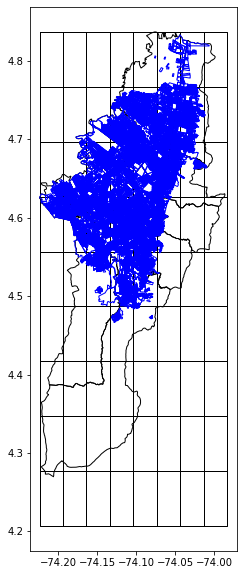

In [361]:
ax = polig_loc_df['geometry'].plot(figsize=(10,10), color='none', edgecolor='black', zorder=3)
poligonos_series.plot(ax=ax, edgecolor='black', color='none')
#conf_arm_loc_df.plot(figsize=(10,10), color='none', edgecolor='red', zorder=3)

#poligonos_df['Poligono'].plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3, ax=ax)
estrat_df['geometry'].plot(figsize=(10,10), color='none', edgecolor='blue', zorder=3, ax=ax)

# .plot(figsize=(10,10), color='none', edgecolor='red', zorder=1, ax=ax)
# .plot(figsize=(10,10), color='none', edgecolor='red', zorder=3, ax=ax)

#pq_esc_pub_df.plot(color='red', ax=ax, edgecolor='blue')

In [454]:

nys = Proj(init='EPSG:3857')
p1 = Point(-74.2235814249999, 4.836779094841296)
p2 = Point(-73.98653427799991, 4.836779094841296)
p1_proj = nys(p1.x, p1.y)
p2_proj = nys(p2.x, p2.y)
print(p1)
print(p2)
print(p1_proj)
print(p2_proj)
d = Point(p1_proj).distance(Point(p2_proj))
d

POINT (-74.22358142499991 4.836779094841296)
POINT (-73.98653427799991 4.836779094841296)
(-8262531.289084068, 539068.4318922834)
(-8236143.32138603, 539068.4318922834)


/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


26387.967698037624

In [459]:
print(p1_proj)

(-8262531.289084068, 539068.4318922834)


In [11]:
(p1.y, p1.x)

(-78.119956, 43.37488)

In [9]:
pp1 = nys(point1.x, point1.y)
pp2 = nys(point2.x, point2.y)

26373.48008398638

In [15]:
d

1.7976931348623157e+308

In [305]:
poligonos_df.iloc[:,95:]

,Tasa Promedio de Asalariados 2011,Tasa Promedio de Asalariados 2014,Tasa Promedio de Asalariados 2017,Tasa de la Población Económicamente Activa 2011,Tasa de la Población Económicamente Activa 2014,Tasa de la Población Económicamente Activa 2017
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,65.328,68.9271,64.8884,292044,311775,358548
3,65.328,68.9271,64.8884,292044,311775,358548
4,0,0,0,0,0,0
...,...,...,...,...,...,...
67,0,0,0,0,0,0
68,0,0,0,0,0,0
69,0,0,0,0,0,0
70,0,0,0,0,0,0


In [243]:
dfff = gpd.read_file('https://bogota-laburbano.opendatasoft.com/explore/dataset/unidad-de-planeamiento13/download/?format=geojson&timezone=America/Bogota&lang=es')

In [245]:
dfff[dfff['uplnombre']=='Suba']

,uplnombre,uplaadmini,objectid,uplarea,shape_len,shape_area,upltipo,uplcodigo,geometry
15,Suba,Dcto. 615-29/12/2006 (Gaceta 454/2007) Mod.=Re...,14,6.529011e+06,0.124117,0.000532,1,UPZ27,"POLYGON ((-74.07564 4.75908, -74.07563 4.75906..."


0        271256.045553
1        900553.560452
2        102235.835106
3         34214.840831
4         71741.145927
             ...      
45046    124744.853789
45047     32588.832772
45048     25637.036983
45049      2819.210843
45050     25346.007134
Length: 45051, dtype: float64

In [359]:
estrat_df.head()

,CODIGO_MAN,ESTRATO,CODIGO_ZON,CODIGO_CRI,NORMATIVA,ACTO_ADMIN,NUMERO_ACT,FECHA_ACTO,ESCALA_CAP,FECHA_CAPT,RESPONSABL,SHAPE_Leng,SHAPE_Area,geometry
0,00913633,0,20,394,DEC394,DEC,394,2017-07-28,None,2017-07-28,560,2203.905471,267773.513997,"POLYGON ((-74.03556 4.82078, -74.03767 4.82167..."
1,108101A1,6,17,394,DEC394,DEC,394,2017-07-28,None,2017-07-28,560,6350.896563,889000.149632,"POLYGON ((-74.00643 4.81884, -74.00860 4.81886..."
2,00913634,0,19,394,DEC394,DEC,394,2017-07-28,None,2017-07-28,560,1488.773919,100924.112922,"POLYGON ((-74.04749 4.82353, -74.04731 4.82342..."
3,00913626,6,17,394,DEC394,DEC,394,2017-07-28,None,2017-07-28,560,745.327665,33775.855324,"POLYGON ((-74.05559 4.82178, -74.05562 4.82159..."
4,00853903,0,19,394,DEC394,DEC,394,2017-07-28,None,2017-07-28,560,1122.296445,70820.836179,"POLYGON ((-74.03431 4.82171, -74.03140 4.82143..."


In [338]:
import numpy as np

chessbool = (np.arange(8)[:, None] + np.arange(8)) % 2 == 0


In [339]:
chessbool

array([[ True, False,  True, False,  True, False,  True, False],
       [False,  True, False,  True, False,  True, False,  True],
       [ True, False,  True, False,  True, False,  True, False],
       [False,  True, False,  True, False,  True, False,  True],
       [ True, False,  True, False,  True, False,  True, False],
       [False,  True, False,  True, False,  True, False,  True],
       [ True, False,  True, False,  True, False,  True, False],
       [False,  True, False,  True, False,  True, False,  True]])

In [342]:
(np.arange(8)[:, None] + np.arange(8))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14]])

In [341]:
np.arange(8)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [368]:
for j in range (0, len(estrat_df)):
        if  poligonos_df['Poligono'][44].intersects(estrat_df['geometry'][j]) == True:
            print(int(j))

In [369]:
estrat_df['geometry']

0        POLYGON ((-74.03556 4.82078, -74.03767 4.82167...
1        POLYGON ((-74.00643 4.81884, -74.00860 4.81886...
2        POLYGON ((-74.04749 4.82353, -74.04731 4.82342...
3        POLYGON ((-74.05559 4.82178, -74.05562 4.82159...
4        POLYGON ((-74.03431 4.82171, -74.03140 4.82143...
                               ...                        
45046    POLYGON ((-74.07779 4.74413, -74.07785 4.74396...
45047    POLYGON ((-74.07452 4.74335, -74.07456 4.74320...
45048    POLYGON ((-74.11403 4.53346, -74.11404 4.53346...
45049    POLYGON ((-74.06053 4.74208, -74.06053 4.74208...
45050    POLYGON ((-74.11451 4.75805, -74.11573 4.75752...
Name: geometry, Length: 45051, dtype: geometry

In [370]:
poligonos_df['Poligono'].to_crs()

0     POLYGON ((-74.22358142499991 4.836779094841296...
1     POLYGON ((-74.22358142499991 4.766779094841295...
2     POLYGON ((-74.22358142499991 4.696779094841296...
3     POLYGON ((-74.22358142499991 4.626779094841296...
4     POLYGON ((-74.22358142499991 4.556779094841295...
                            ...                        
67    POLYGON ((-74.01358142499991 4.556779094841295...
68    POLYGON ((-74.01358142499991 4.486779094841296...
69    POLYGON ((-74.01358142499991 4.416779094841296...
70    POLYGON ((-74.01358142499991 4.346779094841295...
71    POLYGON ((-74.01358142499991 4.276779094841296...
Name: Poligono, Length: 72, dtype: object

In [462]:
print(Point(p1_proj))

POINT (-8262531.289084068 539068.4318922834)


In [463]:
longitud_base

0.2370471469999984

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import gmaps
import gmaps.datasets
import matplotlib.pyplot as plt
from pyproj import Proj

# Import necessary geometric objects from shapely module

from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box
import fiona


# Create Point geometric object(s) with coordinates
point1 = Point(-74.2235814249999, 4.836779094841296)
point2 = Point(-73.98653427799991, 4.836779094841296)
point3 = Point(-73.98653427799991, 4.269664096859796)
point4 = Point(-74.2235814249999, 4.269664096859796)

nys = Proj(init='EPSG:3857')

p1_proj = nys(point1.x, point1.y)
p2_proj = nys(point2.x, point2.y)
p3_proj = nys(point3.x, point3.y)
p4_proj = nys(point4.x, point4.y)

#longitud_base = point1.distance(point2)
#longitud_altura = point2.distance(point3)

longitud_base = Point(p1_proj).distance(Point(p2_proj))
longitud_altura = Point(p2_proj).distance(Point(p3_proj))



/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [9]:
b1 = 1000
h1 = 1000
topLeft = p1_proj
topRight = Point(Point(p1_proj).x + math.ceil(longitud_base/b1)*b1, Point(p2_proj).y)
bottomRight = Point(topRight.x, Point(p2_proj).y - math.ceil(longitud_altura/h1)*h1)
bottomLeft = Point(Point(p1_proj).x, bottomRight.y) 

poligono_mayor = Polygon([topLeft, topRight, bottomRight, bottomLeft])

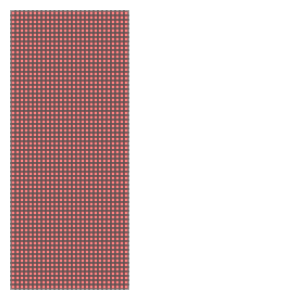

In [10]:
cols = np.linspace(np.array(bottomLeft)[0], np.array(bottomRight)[0], math.ceil(longitud_base/b1) + 1) 
rows = np.linspace(np.array(topLeft)[1], np.array(bottomLeft)[1], math.ceil(longitud_altura/h1) + 1)     

poligonos = [Polygon([Point(cols[i], rows[j]), Point(cols[i+1], rows[j]), Point(cols[i+1], rows[j+1]), 
                      Point(cols[i], rows[j+1]), Point(cols[i], rows[j])]) for i in range(len(cols)-1) 
             for j in range(len(rows)-1)]
poligonos_series = gpd.GeoSeries(poligonos)

grid = MultiPolygon(poligonos)
grid